In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model

2024-05-13 17:47:13.060886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 17:47:13.060978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 17:47:13.156112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv')
test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


Text(0.5, 1.0, 'Number of children in each age group')

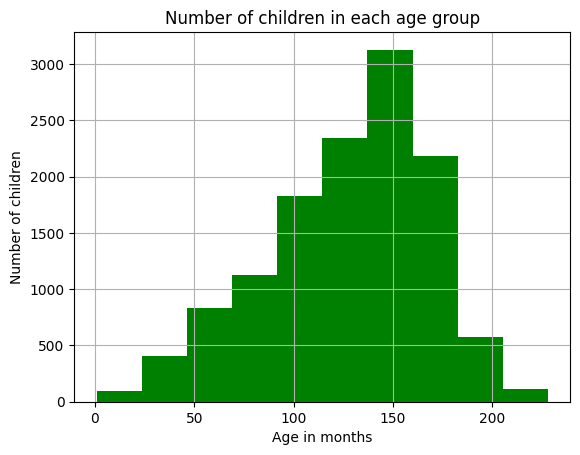

In [3]:
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5, 1.0, 'Relationship between number of children and bone age z score')

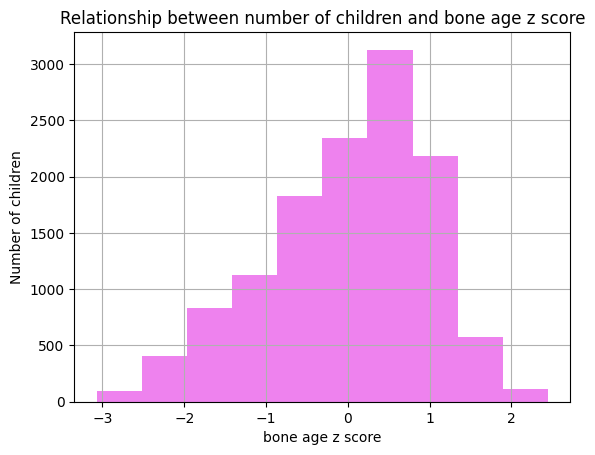

In [4]:
std_bone_age = train_df['boneage'].std()
mean_bone_age = train_df['boneage'].mean()
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)
train_df['bone_age_z'].hist(color = 'violet')
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

In [5]:
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

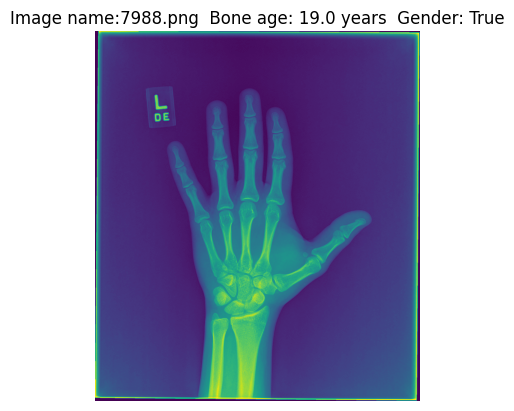

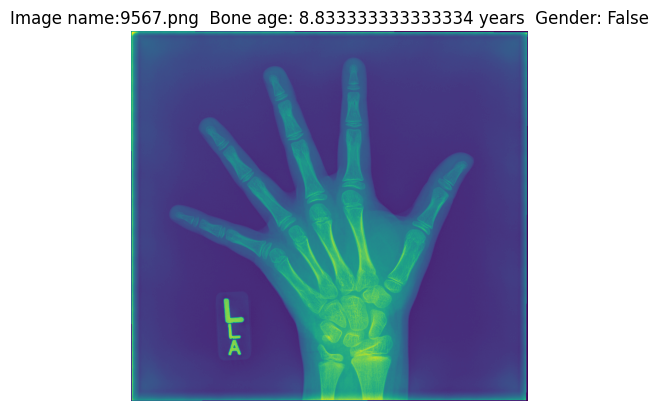

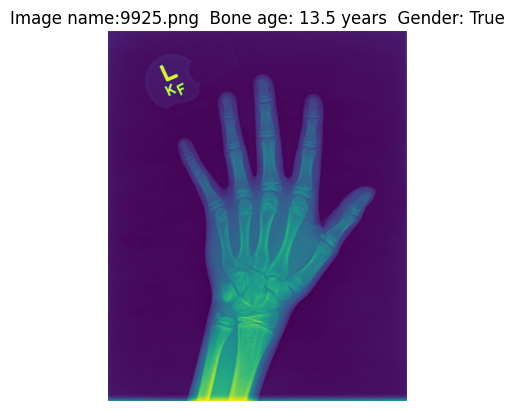

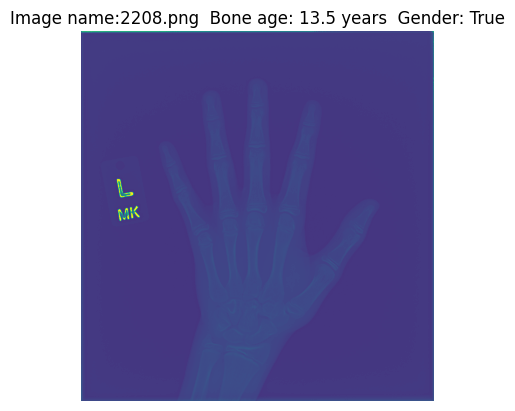

In [6]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','male']].sample(4).values:
    img = mpimg.imread('/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = '/kaggle/input/rsna-bone-age/boneage-test-dataset',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 200 images belonging to 1 classes.


In [8]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'raw'
                            )) 

Found 2523 validated image filenames.


In [9]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [10]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'linear'))
model.compile(optimizer = "adam" , loss = 'mse' , metrics = [mae_in_months])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,524,929 (9.63 MB)

 Trainable params: 2,523,841 (9.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [12]:
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


#fit model
history_1 = model.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= red_lr_plat)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/315 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - loss: 210.8488 - mae_in_months: 338.8512

I0000 00:00:1715622630.929855      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715622630.953433      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/315 ━━━━━━━━━━━━━━━━━━━━ 7:05 2s/step - loss: 79.0019 - mae_in_months: 184.8591

W0000 00:00:1715622709.545967      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - loss: 20.4906 - mae_in_months: 73.3716 - val_loss: 2.3615 - val_mae_in_months: 43.2124 - learning_rate: 0.0010
Epoch 2/60
  1/315 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - loss: 0.8704 - mae_in_months: 31.1937

W0000 00:00:1715623084.010826      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8704 - mae_in_months: 31.1937 - val_loss: 3.3694 - val_mae_in_months: 46.0280 - learning_rate: 0.0010
Epoch 3/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 313s 971ms/step - loss: 0.8720 - mae_in_months: 31.9361 - val_loss: 0.7483 - val_mae_in_months: 31.9351 - learning_rate: 0.0010
Epoch 4/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - loss: 0.8053 - mae_in_months: 31.2272 - val_loss: 1.0075 - val_mae_in_months: 33.2636 - learning_rate: 0.0010
Epoch 5/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 315s 976ms/step - loss: 0.8288 - mae_in_months: 30.2313 - val_loss: 1.0805 - val_mae_in_months: 34.3564 - learning_rate: 0.0010
Epoch 6/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - loss: 0.6186 - mae_in_months: 24.2996 - val_loss: 0.6082 - val_mae_in_months: 25.8982 - learning_rate: 0.0010
Epoch 7/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 314s 973ms/step - loss: 0.7459 - mae_in_months: 28.3466 - val_loss: 3.4387 - val_mae_in_months: 39.5968 - learning_rate: 0.0010
Epoch 8/60
31

In [13]:
pred_1 = mean_bone_age + std_bone_age*(model.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


In [14]:
rmse_1 = np.sqrt(np.mean(((pred_1 - test_months)**2)))

In [15]:
print("The Root Mean Square Value using CNN is :",rmse_1 / 12)

The Root Mean Square Value using CNN is : 4.205590289437088


In [16]:
from tensorflow.keras.applications import ResNet50 #ResNet50
model_2=ResNet50(input_shape=(256,256,3),
                 include_top=False,
                 weights='imagenet') #VGG19
for layer in model_2.layers:
  layer.trainable=False
x=model_2.output
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
predictions=Dense(1,activation='linear')(x)
model_final_2=Model(model_2.input,predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model_final_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_final_2.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
history_2 = model_final_2.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= red_lr_plat)

Epoch 1/60
  2/315 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - loss: 5.8780 - mae_in_months: 75.1453   

W0000 00:00:1715632281.887490      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/315 ━━━━━━━━━━━━━━━━━━━━ 7:03 1s/step - loss: 6.9277 - mae_in_months: 87.0649

W0000 00:00:1715632292.811674      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - loss: 1.7916 - mae_in_months: 41.4888 - val_loss: 0.9342 - val_mae_in_months: 28.4476 - learning_rate: 0.0010
Epoch 2/60


W0000 00:00:1715632600.030231      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 1.0588 - mae_in_months: 33.4299 - val_loss: 0.7601 - val_mae_in_months: 29.3391 - learning_rate: 0.0010
Epoch 3/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 361s 980ms/step - loss: 0.8980 - mae_in_months: 31.4353 - val_loss: 0.7061 - val_mae_in_months: 29.2154 - learning_rate: 0.0010
Epoch 4/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5847 - mae_in_months: 25.1293 - val_loss: 0.5893 - val_mae_in_months: 26.7130 - learning_rate: 0.0010
Epoch 5/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 320s 978ms/step - loss: 0.8220 - mae_in_months: 30.0322 - val_loss: 1.1224 - val_mae_in_months: 35.3846 - learning_rate: 0.0010
Epoch 6/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.8956 - mae_in_months: 32.9260 - val_loss: 0.5785 - val_mae_in_months: 25.3651 - learning_rate: 0.0010
Epoch 7/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 316s 980ms/step - loss: 0.7409 - mae_in_months: 28.3311 - val_loss: 1.1632 - val_mae_in_months: 34.7560 - learning_rate: 0.0010
Epoch 8/60


In [19]:
pred_2 = mean_bone_age + std_bone_age*(model_final_2.predict(test_X, batch_size = 32, verbose = True))

 2/79 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step

W0000 00:00:1715641833.065780      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step


W0000 00:00:1715641849.830222      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [20]:
rmse_2 = np.sqrt(np.mean(((pred_2 - test_months)**2)))

In [21]:
print("The Root Mean Square Value using ResNet50 is :",rmse_2 / 12)

The Root Mean Square Value using ResNet50 is : 4.066447241175613


In [22]:
from keras.applications.vgg19 import VGG19 #VGG19
model_3=VGG19(input_shape=(256,256,3),
                 include_top=False,
                 weights='imagenet') #VGG19
for layer in model_3.layers:
  layer.trainable=False
x=model_3.output
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
predictions=Dense(1,activation='linear')(x)
model_final_3=Model(model_3.input,predictions)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
model_final_3.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_final_3.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,287,553 (77.39 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
history_3 = model_final_3.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= red_lr_plat)

Epoch 1/60
  1/315 ━━━━━━━━━━━━━━━━━━━━ 4:34:10 52s/step - loss: 2.8025 - mae_in_months: 57.5782

W0000 00:00:1715641922.546952      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.8276 - mae_in_months: 29.5321

W0000 00:00:1715642250.380602      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - loss: 0.8270 - mae_in_months: 29.5196 - val_loss: 0.6186 - val_mae_in_months: 28.3544 - learning_rate: 0.0010
Epoch 2/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7118 - mae_in_months: 28.3969 - val_loss: 0.2797 - val_mae_in_months: 17.4865 - learning_rate: 0.0010
Epoch 3/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 0.4698 - mae_in_months: 21.9750 - val_loss: 0.3520 - val_mae_in_months: 18.1907 - learning_rate: 0.0010
Epoch 4/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.4049 - mae_in_months: 21.3840 - val_loss: 0.4571 - val_mae_in_months: 22.3409 - learning_rate: 0.0010
Epoch 5/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 317s 983ms/step - loss: 0.4016 - mae_in_months: 20.3051 - val_loss: 0.5061 - val_mae_in_months: 23.9803 - learning_rate: 0.0010
Epoch 6/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.4943 - mae_in_months: 23.6013 - val_loss: 0.3191 - val_mae_in_months: 18.9148 - learning_rate: 0.0010
Epoch 7/60
315/31

In [25]:
pred_3 = mean_bone_age + std_bone_age*(model_final_3.predict(test_X, batch_size = 32, verbose = True))

 2/79 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step

W0000 00:00:1715651615.752189      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 659ms/step


W0000 00:00:1715651667.176020      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
rmse_3 = np.sqrt(np.mean(((pred_3 - test_months)**2)))

In [27]:
print("The Root Mean Square Value using VGG19 is :",rmse_3 / 12)

The Root Mean Square Value using VGG19 is : 4.506710089408536


In [28]:
model_1 =InceptionV3(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
for layer in model_1.layers:
  layer.trainable=False
x=model_1.output
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
predictions=Dense(1,activation='linear')(x)
model_final=Model(model_1.input,predictions)


#compile model
model_final.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_final.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 127, 127,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d_5[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [29]:
history_5 = model_final.fit(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= red_lr_plat)

Epoch 1/60
  2/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - loss: 1.3823 - mae_in_months: 39.6063  

W0000 00:00:1715651731.862628      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


273/315 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - loss: 3.5879 - mae_in_months: 45.4948

W0000 00:00:1715652106.507125      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - loss: 3.2561 - mae_in_months: 42.9999 - val_loss: 0.4236 - val_mae_in_months: 22.1734 - learning_rate: 0.0010
Epoch 2/60
  1/315 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - loss: 0.5414 - mae_in_months: 23.0372

W0000 00:00:1715652163.686679      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.5414 - mae_in_months: 23.0372 - val_loss: 0.2513 - val_mae_in_months: 16.6110 - learning_rate: 0.0010
Epoch 3/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 318s 988ms/step - loss: 0.3343 - mae_in_months: 18.8551 - val_loss: 0.3380 - val_mae_in_months: 17.7658 - learning_rate: 0.0010
Epoch 4/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1872 - mae_in_months: 14.2195 - val_loss: 0.4645 - val_mae_in_months: 22.6056 - learning_rate: 0.0010
Epoch 5/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 322s 997ms/step - loss: 0.3024 - mae_in_months: 18.0464 - val_loss: 0.2704 - val_mae_in_months: 16.4812 - learning_rate: 0.0010
Epoch 6/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 0.2090 - mae_in_months: 15.2718 - val_loss: 0.4333 - val_mae_in_months: 22.6007 - learning_rate: 0.0010
Epoch 7/60
315/315 ━━━━━━━━━━━━━━━━━━━━ 320s 988ms/step - loss: 0.2844 - mae_in_months: 17.4167 - val_loss: 0.3302 - val_mae_in_months: 18.3684 - learning_rate: 0.0010
Epoch 8/60


In [30]:
model_final.save('./Inception_model.h5')

 3/79 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step

W0000 00:00:1715661427.198714      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step


W0000 00:00:1715661450.383921      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/tmp/ipykernel_24/1088193712.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0,


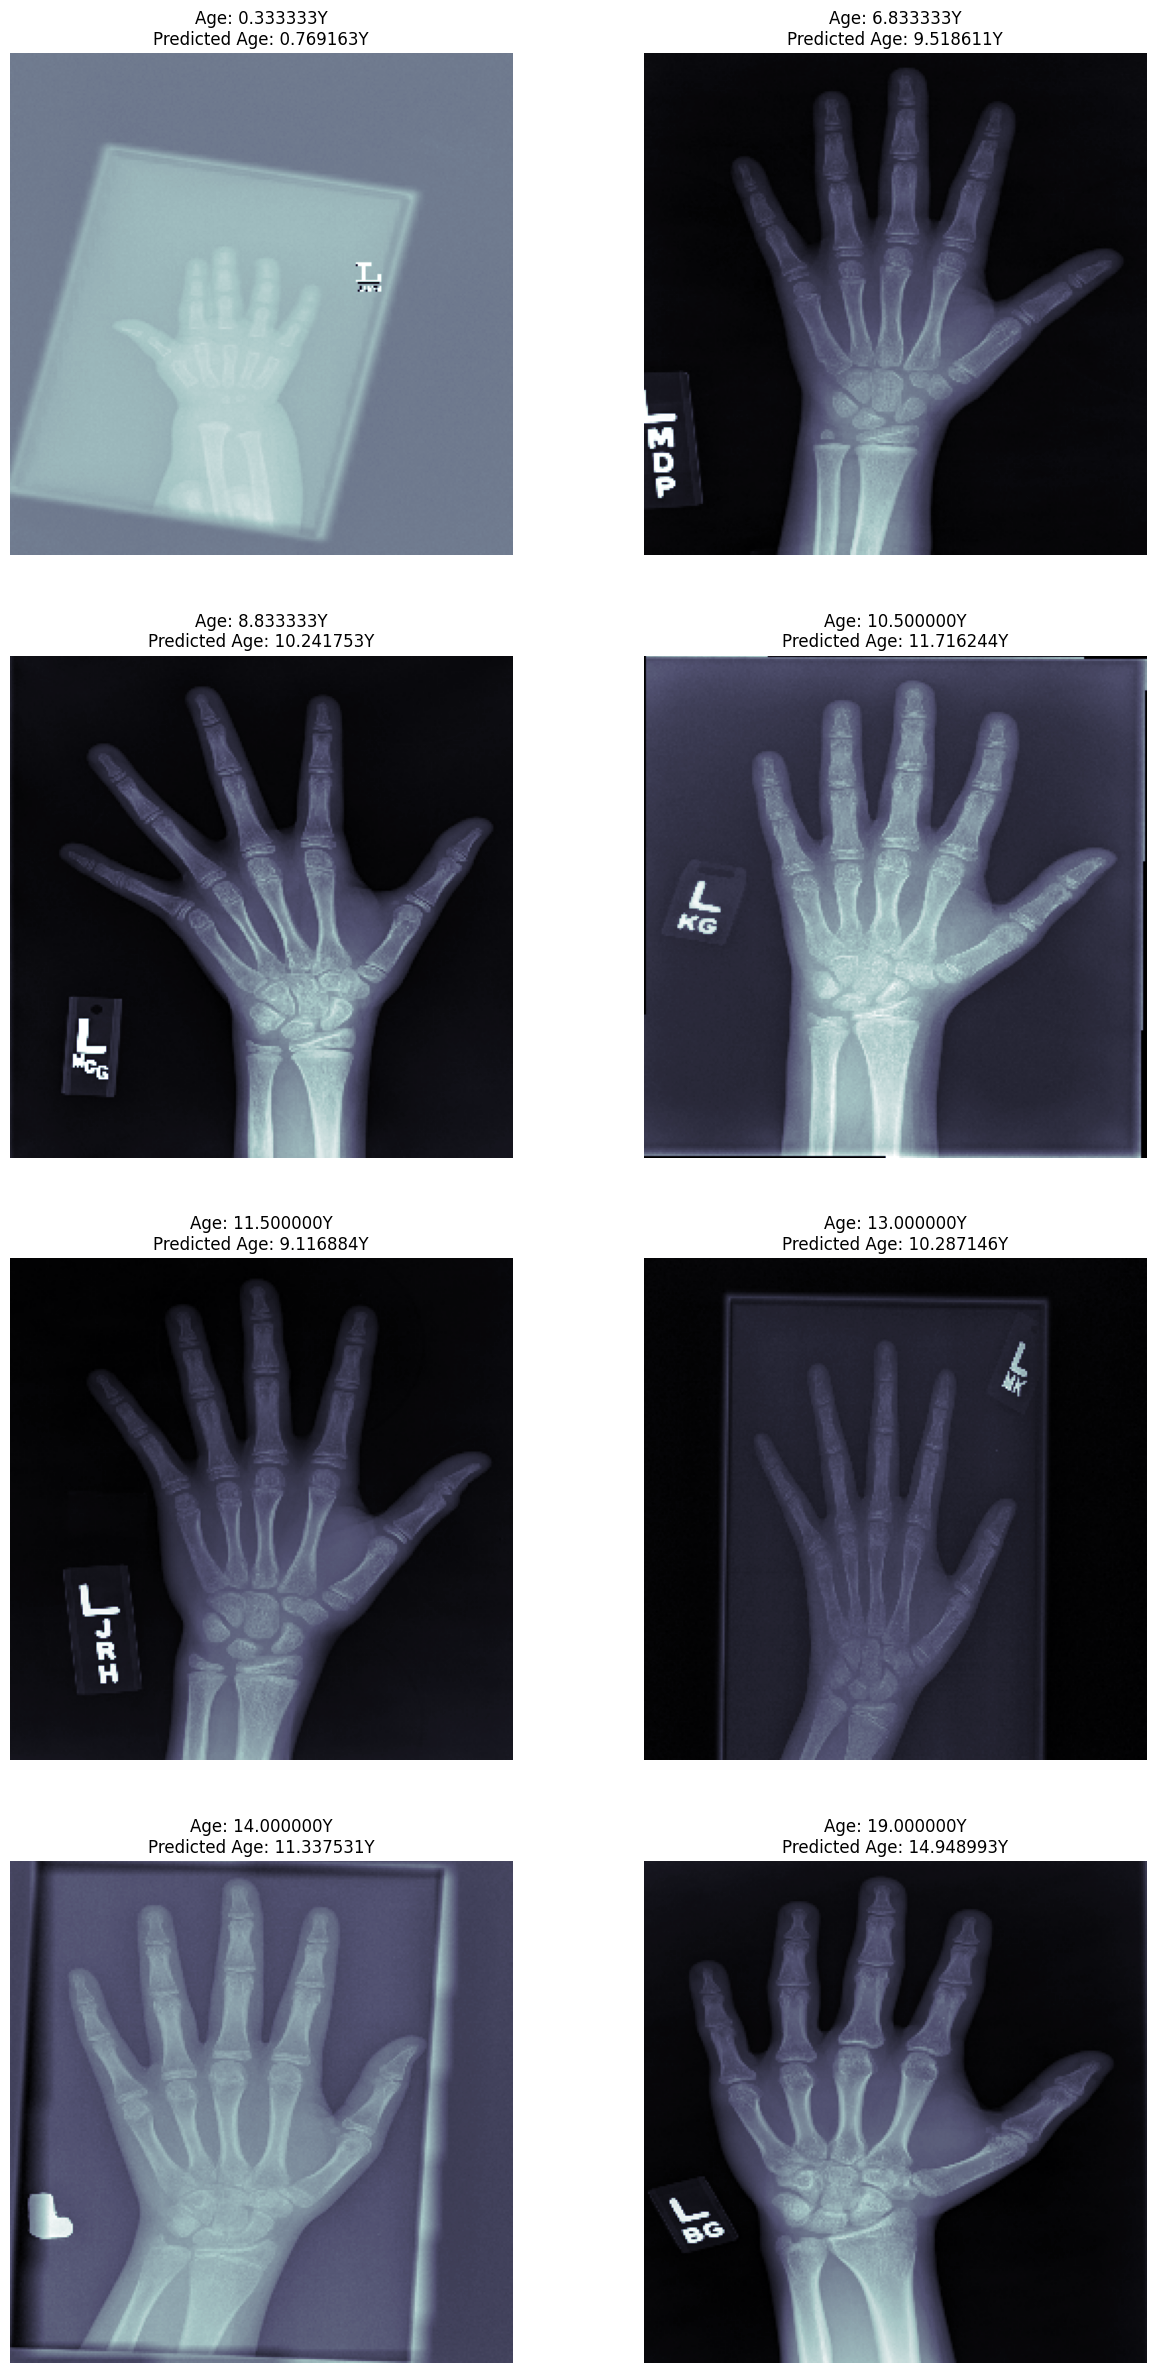

In [31]:
model_final.load_weights('Inception_model.h5')
pred = mean_bone_age + std_bone_age*(model_final.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

In [32]:
rmse_4 = np.sqrt(np.mean(((pred - test_months)**2)))

In [33]:
print("The Root Mean Square Value using InspectionV3 is :",rmse_4 / 12)

The Root Mean Square Value using InspectionV3 is : 4.723349286174056
